# Publishing Figures - Multi Kappa
This obtains all figures for a combining all simulations of differing optical depth that only require the surface variables.

In [129]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy, lapse_moist
from isca_tools.utils.constants import L_v, c_p
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory
from isca_tools.papers.byrne_2021 import get_quant_ind
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
import numpy_indexed
from scipy.stats import median_abs_deviation
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
from isca_tools.utils.radiation import frierson_atmospheric_heating
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [6]:
# Load dataset
var_keep = ['temp', 'sphum', 'height']
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
# exp_names = exp_names[2:-1]     # get rid of coldest 2 and warmest simulation as don't work well
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])
    ds += [ds_use]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
tau_lw = np.asarray(tau_lw)
p_surface = float(ds[0].pfull[-1]) * 100

100%|██████████| 8/8 [00:13<00:00,  1.65s/it]


## Get datasets
Get one dataset for each $\kappa$, combining the desired latitudes: `ds_all`. This combines all or just the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [468]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [501]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
season = 'all'
# season = 'summer'
# season = 'winter'
if season == 'summer':
    season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    season_months = {'nh': [12, 1, 2], 'sh': [6, 7, 8]}   # JJA for NH and DJF for SH

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))[var_keep]
        ds_use = ds_use.sel(pfull=np.inf, method='nearest')      # only keep the surface values - get rid of pfull coordinate
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer' or season == 'winter':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(lat_min, lat_max)) 
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-lat_max, -lat_min))  
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

100%|██████████| 8/8 [01:17<00:00,  9.67s/it]


## Near Surface Temperature Quantile
Plot quantile of near surface air temperature vs global average near surface air temperature for a given latitude band.

Near surface air temperature is the temperature at the lowest pressure level.

Here, we compute the quantile at each latitude coordinate across all longitudes and time and then average over these.

We average over all times after 2 years because, from the spin up plot above, after 2 years, the simulation has converged into a regular pattern, with a net TOA flux centered on 0.

In [502]:
quantiles_all = np.arange(1, 100)
median_quant_ind = np.where(quantiles_all==50)[0][0]
n_quant_all = len(quantiles_all)
n_lat = len(ds_all[0].lat)
# two different types of temperature quantiles, p is actual percentile. x is averaged over given percentile.
temp_quant_p = np.zeros((n_exp, n_lat, n_quant_all))
sphum_quant_p = np.zeros((n_exp, n_lat, n_quant_all))
mse_quant_p = np.zeros((n_exp, n_lat, n_quant_all))
temp_mean = np.zeros((n_exp, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
temp_median = np.zeros((n_exp, n_lat))
mse_mean = np.zeros((n_exp, n_lat))
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        sphum_mean[i] = ds_all[i].sphum.mean(dim='lon_time')
        temp_median[i] = ds_all[i].temp.median(dim='lon_time')
        mse_mean[i] = moist_static_energy(ds_all[i].temp, ds_all[i].sphum, ds_all[i].height).mean(dim='lon_time')
        temp_quant_p[i] = ds_all[i].temp.quantile(quantiles_all/100, dim='lon_time').transpose()
        sphum_quant_p[i] = ds_all[i].sphum.quantile(quantiles_all/100, dim='lon_time').transpose()
        mse_quant_p[i] = moist_static_energy(ds_all[i].temp, ds_all[i].sphum,
                                             ds_all[i].height).quantile(quantiles_all/100, dim='lon_time').transpose()
        pbar.update(1)

100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


In [503]:
# For given quantiles, plot quantile vs average temp for each latitude.
# Then fit best line to this to get simulated gradient, combining all kappa values
quant_plot = [90, 95, 99]
quant_plot_ind = numpy_indexed.indices(quantiles_all, quant_plot)
n_quant_plot = len(quant_plot)
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

def get_gradient(temp_quant, temp_av, ref_ind):
    """
    Gets gradient of temperature of given quantile vs average temperature

    Args:
        temp_quant: [n_exp]
        temp_av: [n_exp]
        ref_ind: int

    Returns:
        int
            Gradient
        [n_exp]
            Predicted temperature for each experiment
    """
    fit_func = lambda x, m: temp_quant[ref_ind] + m*(x-temp_av[ref_ind])     # Straight line through the ref point
    param = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant)[0]
    return param, fit_func(temp_av, param)

tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]
temp_quant_grad = np.zeros((n_lat, n_quant_plot))
temp_quant_grad_fit = np.zeros((n_exp, n_lat, n_quant_plot))
for i in range(n_lat):
    for j in range(n_quant_plot):
        temp_quant_grad[i, j], temp_quant_grad_fit[:, i, j] = get_gradient(temp_quant_p[:, i, quant_plot_ind[j]],
                                                                           temp_mean[:, i], tau_ref_ind)

## Figure 4 of O'Gorman & Schneider 2009
### Tropics
In the plot below, all the gradients are below 1, indicating that the hottest days warm less quickly than the average day. If we look at the largest $\kappa$ values, it is also clear that the gradient here is a lot larger than the gradient at lower $\kappa$ and thus causes the gradients to be larger than maybe they appear by eye.

Gradient of best fit line for [90, 95, 99] percentiles: [0.96 0.96 0.96]


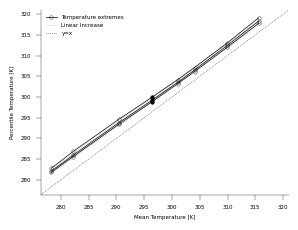

In [504]:
trend_line_on = True
save_trend_fig = False

tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]

temp_mean_weight = np.average(temp_mean, axis=1, weights=lat_weights)
temp_quant_weight = np.average(temp_quant_p, axis=1, weights=lat_weights)

fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for j in range(n_quant_plot):
    ax.plot(temp_mean_weight,
            temp_quant_weight[:, quant_plot_ind[j]],
            marker='o',
            label='Temperature extremes' if j==0 else None,
            color='k', fillstyle='none')
    if trend_line_on:
        # Filled circle for reference simulation
        ax.plot(temp_mean_weight[tau_ref_ind],
                temp_quant_weight[tau_ref_ind, quant_plot_ind[j]],
                marker='o', color='k', fillstyle='full')
        if j==n_quant_plot-1:
            label = 'Linear Increase'
        else:
            label = None
        ax.plot(temp_mean_weight,
                np.average(temp_quant_grad_fit[:, :, j], axis=1, weights=lat_weights),
                linestyle=':', color='k', alpha=0.3, label=label)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
lim_new = [np.asarray([xlim, ylim]).min(), np.asarray([xlim, ylim]).max()]
ax.plot(lim_new, lim_new, 'k:', alpha=0.75, label='y=x')
ax.set_ylim(lim_new)
ax.set_xlim(lim_new)
if trend_line_on:
    ax.legend()
ax.set_xlabel(f'Mean Temperature [K]')
ax.set_ylabel(f'Percentile Temperature [K]')
if save_fig or save_trend_fig:
    if trend_line_on:
        file_name = f"{region.lower()}_trend"
    else:
        file_name = f"{region.lower()}_no_trend"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight',
                pad_inches=save_pad_inches)
print(f'Gradient of best fit line for {quant_plot} percentiles: {np.round(np.average(temp_quant_grad, weights=lat_weights, axis=0), 2)}')

## Theory for Temperature change relative to median change between subsequent $\kappa$
The below shows the predicted amplification factor compared to the actual one. The denominator in $\delta T(x)/\delta \overline{T}$ is the change in the median temperature as the theory can predict this too.

In [505]:
# get theory predictions for all quantiles
delta_temp_quant = np.diff(temp_quant_p, axis=0)
delta_temp_median = np.diff(temp_median, axis=0)
delta_mse_ratio = np.diff(mse_quant_p, axis=0)/np.expand_dims(np.diff(mse_mean, axis=0), axis=-1)

delta_temp_quant_theory = {method: np.zeros((n_exp-1, n_lat, n_quant_all)) for method in
                           ['linear', 'const_rh', 'squared', 'squared_lambda']}
for method in delta_temp_quant_theory:
    for i in range(n_lat):
        delta_temp_quant_theory[method][:, i] = \
                get_delta_temp_quant_theory(temp_mean[:, i], sphum_mean[:, i], temp_quant_p[:, i], sphum_quant_p[:, i], p_surface,
                                            const_rh=True if method=='const_rh' else False,
                                            delta_mse_ratio=delta_mse_ratio[:, i] if 'lambda' in method else None,
                                            taylor_level='squared' if method[0] == 's' else 'linear_rh_diff')

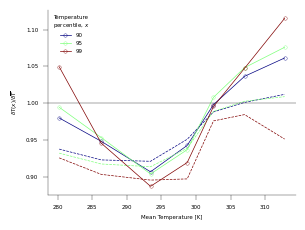

In [506]:
theory_method = 'linear'
color_seq = plt.cm.jet(np.linspace(0,1,len(quant_plot)))

save_amp_factor_fig=False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
for j in range(n_quant_plot):
    # for difference between simulations, make x-axis the average between the two mean temperatures
    ax.plot(moving_average(temp_mean_weight, 2),
            np.average(delta_temp_quant[:, :, quant_plot_ind[j]]/delta_temp_median, axis=1, weights=lat_weights),
            color=color_seq[j], marker='o', fillstyle='none', label=quant_plot[j])
    ax.plot(moving_average(temp_mean_weight, 2),
            np.average(delta_temp_quant_theory[theory_method][:, :, quant_plot_ind[j]]/
                       delta_temp_quant_theory[theory_method][:, :, median_quant_ind],
                       axis=1, weights=lat_weights), color=color_seq[j], linestyle='--')
ax.legend(title='Temperature\npercentile, $x$')
xlim = ax.get_xlim()
ax.hlines(1, xlim[0], xlim[1], color='k', linewidth=ax_linewidth)
ax.set_xlim(xlim)
ax.set_xlabel(f'Mean Temperature [K]')
ax.set_ylabel('$\delta T(x)/\delta \overline{T}$')
if save_fig or save_amp_factor_fig:
    file_name = f'{region.lower()}_amplification_factor_{theory_method}'
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf", dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

## Figure 2 of Byrne 2021 - combining $\kappa$
The plot below indicates is found by plotting temp_quant vs temp_median (one marker for each $\kappa$) and the taking the gradient. I do this for each quantile, so I obtain a single value for each quantile.

I am using the actual percentile (not the average over a given percentile as used in Byrne 2021).

To see if the scaling factor is different for warmer vs colder climates, I compute the gradients using a subset of $\kappa$ values. For colder climates, I use $\kappa=0.2, 0.3, 0.6, 1$ and force the line through $\kappa=1$. For warmer climates, I use $\kappa=1, 1.5, 2, 3.5, 6$ and force the line through $\kappa=1$. The solid line includes all $\kappa$ and is forced through $\kappa = 1$.

I also do the same with the theoretical temperature. To get the theoretical temperature, I start with the simulated temperature for the coldest simulation, and then add the theoretical temperature difference.

In [507]:
# theory2 adds the same theoretical delta_temp to theory prediction of previous kappa so errors accumulate
temp_quant_theory2 = {method: temp_quant_p.copy() for method in ['linear', 'const_rh', 'squared', 'squared_lambda']}
for method in delta_temp_quant_theory:
    for j in range(n_exp-1):
        temp_quant_theory2[method][1+j] = temp_quant_theory2[method][j] + delta_temp_quant_theory[method][j]

In [508]:
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1)[0], np.where(tau_lw>=1)[0]]
sf_tau_ref = [1, 1, 1]
n_sf = len(sf_tau_use)
# all temperatures averaged above x=0 - same as temp_av except for no area averaging
scaling_factor = np.zeros((n_sf, n_lat, n_quant_all))

scaling_factor_theory = {method: np.zeros((n_sf, n_lat, n_quant_all)) for method in delta_temp_quant_theory}

for i in range(n_sf):
    sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]
    for j in range(n_quant_all):
        # The theory predicts median change but not mean hence I use median rather than mean.
        # This means can get theoretical scale factor rather than using simulated mean.
        # This means x=50 will correspond to y=1 in all plots below.
        # Straight line through the ref point
        for k in range(n_lat):
            scaling_factor[i, k, j] = get_gradient(temp_quant_p[sf_tau_use[i], k, j], temp_median[sf_tau_use[i], k], sf_tau_ref_ind)[0]
            for method in scaling_factor_theory:
                # Use theory2 version for theoretical scaling factor as errors compounded - makes most sense to me
                scaling_factor_theory[method][i, k, j] = get_gradient(temp_quant_theory2[method][sf_tau_use[i], k, j],
                                                           temp_quant_theory2[method][sf_tau_use[i], k, median_quant_ind],
                                                           sf_tau_ref_ind)[0]

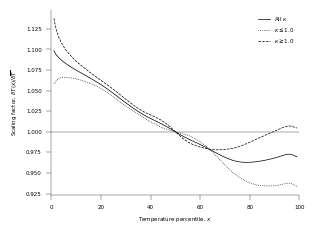

In [509]:
save_sf_fig = True
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quantiles_all, np.average(scaling_factor[0], axis=0, weights=lat_weights), color='k', label='All $\kappa$')
ax.plot(quantiles_all, np.average(scaling_factor[1], axis=0, weights=lat_weights), color='k', linestyle=':',
        label=f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$')
ax.plot(quantiles_all, np.average(scaling_factor[2], axis=0, weights=lat_weights), color='k', linestyle='--',
        label= f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$')
ax.hlines(1, 0, 100, lw=ax_linewidth, color='k')
# # Remove some of the lines but keep ylims the same
# ax.lines.pop(1)
# ax.lines.pop(1)
ax.legend()
ax.set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if save_fig or save_sf_fig:
    file_name = f"scaling_factor_multi_kappa_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf", dpi=dpi['monochrome'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

The solid blue line below is the same as the solid black line above. The black lines show the theoretical prediction for the blue line, combining all kappa values.

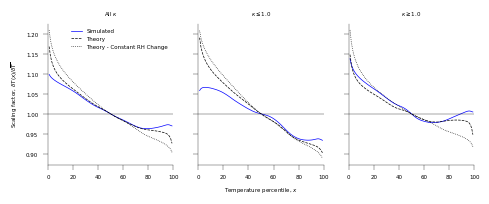

In [520]:
save_sf_theory_fig = True
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,3, figsize=(width['two_col'], width['two_col']/ar/(0.75*3)), sharey=True, sharex=True)
for i in range(n_sf):
    ax[i].plot(quantiles_all, np.average(scaling_factor[i], axis=0, weights=lat_weights), color='b', label='Simulated')
    ax[i].plot(quantiles_all, np.average(scaling_factor_theory['linear'][i], axis=0, weights=lat_weights), color='k', linestyle='--',
            label=f'Theory')
    ax[i].plot(quantiles_all, np.average(scaling_factor_theory['const_rh'][i], axis=0, weights=lat_weights), color='k', linestyle=':',
            label= f'Theory - Constant RH Change')
    ax[i].hlines(1, 0, 100, linewidth=ax_linewidth, color='k')
ax[0].set_title(f'All $\kappa$')
ax[1].set_title(f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$')
ax[2].set_title(f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$')
# # Remove some of the lines but keep ylims the same
# ax.lines.pop(2)
# ax.lines.pop(1)
ax[0].legend()
ax[0].set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax[1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if save_fig or save_sf_theory_fig:
    file_name = f"scaling_factor_theory_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

## Approximations of Theory
Below, I investigate the 3 approximations that go into the aquaplanet theory.

In [511]:
lambda_p = {var: np.zeros((n_sf, n_lat, n_quant_all)) for var in ['temp', 'sphum', 'mse', 'mse2']}

for i in range(n_sf):
    sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]
    for j in range(n_quant_all):
        # The theory predicts median change but not mean hence I use median rather than mean.
        # This means can get theoretical scale factor rather than using simulated mean.
        # This means x=50 will correspond to y=1 in all plots below.
        # Straight line through the ref point
        for k in range(n_lat):
            lambda_p['temp'][i, k, j] = get_gradient(temp_quant_p[sf_tau_use[i], k, j], temp_mean[sf_tau_use[i], k], sf_tau_ref_ind)[0]
            lambda_p['sphum'][i, k, j] = get_gradient(sphum_quant_p[sf_tau_use[i], k, j], sphum_mean[sf_tau_use[i], k], sf_tau_ref_ind)[0]
            lambda_p['mse'][i, k, j] = get_gradient(mse_quant_p[sf_tau_use[i], k, j], mse_mean[sf_tau_use[i], k], sf_tau_ref_ind)[0]
            lambda_p['mse2'][i, k, j] = get_gradient(c_p * temp_quant_p[sf_tau_use[i], k, j] + L_v * sphum_quant_p[sf_tau_use[i], k, j],
                                                     c_p * temp_mean[sf_tau_use[i], k] + L_v * sphum_mean[sf_tau_use[i], k],
                                                     sf_tau_ref_ind)[0]

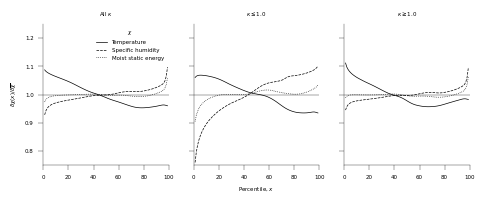

In [521]:
save_lambda_fig = True
fig, ax = plt.subplots(1,3, figsize=(width['two_col'], width['two_col']/ar/(0.75*3)), sharey=True, sharex=True)
labels = ['Temperature','Specific humidity', 'Moist static energy']
linestyles = ['-', '--', ':']
for i in range(n_sf):
    for j, var in enumerate(['temp', 'sphum', 'mse']):
        ax[i].plot(quantiles_all, np.average(lambda_p[var][i], axis=0, weights=lat_weights), label=labels[j], linestyle=linestyles[j],
                   color='k')
    ax[i].hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax[0].legend(title='$\chi$')
ax[0].set_title(f'All $\kappa$')
ax[1].set_title(f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$')
ax[2].set_title(f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$')
ax[1].set_xlabel('Percentile, $x$')
ax[0].set_ylabel('$\delta \chi(x)/\delta \overline{\chi}$')
ax[0].set_ylim(0.75,1.25)
ax[0].set_xlim(0, 100)
# plt.tight_layout()
if save_fig or save_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

There are three approximations that go into the theory:
1. $\lambda = \delta h(x)/\delta \overline{h} = 1$

    The validity of this is shown by the green line in the $\delta Ocean/\delta \overline{Ocean}$ plot above. This should be equal to 1.
    In the plot below, we see that whenever $\lambda < 1$, the green line, which includes the exact $\lambda$, predicts a smaller temperature change than the orange line which is the same apart from assuming $\lambda=1$.

2. $\delta h(x) \approx c_p \delta T(x) + L_v \delta q(x)$

    The validity of this is shown by comparing the green lines in the $\delta Ocean/\delta \overline{Ocean}$ plot above. If this approximation was exact, we would expect them to match up exactly.
   In the plot below, we see that whenever $c_p \delta T(x) + L_v \delta q(x) > \delta h(x)$, the predicted temperature change by the most complete theory (green line) is less than the actual simulated value (blue line).

3. Taylor series for $\delta q(x)$ in terms of $\delta T(x)$ and $\delta r(x)$ as well as for $\delta \overline{q}$

    The most accurate taylor series I use is to include squared, $\delta T^2$, nonlinear, $\delta T \delta r$, and linear terms. The extent to which just the linear terms are necessary can be evaluated by comparing the orange and black dashed line below. The only difference between them is that the orange line retains all the terms in the taylor series.

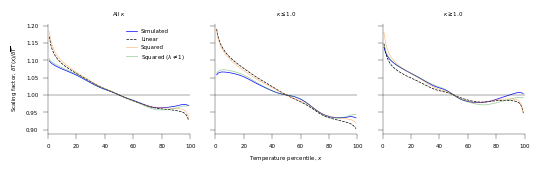

In [513]:
save_approx_fig = False
fig, ax = plt.subplots(1,3, figsize=(width['two_col'], width['two_col']/ar/(0.75*3)), sharey=True, sharex=True)

for i in range(n_sf):
    ax[i].plot(quantiles_all, np.average(scaling_factor[i], axis=0, weights=lat_weights), label = 'Simulated', color='b')
    ax[i].plot(quantiles_all, np.average(scaling_factor_theory['linear'][i], axis=0, weights=lat_weights),
               label='Linear', color='k', linestyle='--')
    ax[i].plot(quantiles_all, np.average(scaling_factor_theory['squared'][i], axis=0, weights=lat_weights),
               label='Squared', color=default_colors[1], alpha=0.5)
    ax[i].plot(quantiles_all, np.average(scaling_factor_theory['squared_lambda'][i], axis=0, weights=lat_weights),
               label='Squared ($\lambda \\neq 1$)', color=default_colors[2], alpha=0.5)
    ax[i].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax[0].set_title(f'All $\kappa$')
ax[1].set_title(f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$')
ax[2].set_title(f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$')
ax[0].legend()
ax[1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax[0].set_xlim(0,100)
plt.tight_layout()

if save_fig or save_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/scaling_factor_approx_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Probability Density Function
#### Tropics
Below, I plot how the temperature distribution relative to the median changes with warming. Clearly, the coldest days become closer to the median as optical depth increases (blue $\rightarrow$ red). The hottest days also become closer to the median as optical depth increases for the lower optical depths. But for the hottest simulations, as the optical depth increases, the hottest days become hotter.
#### Extratropics
In the extratropics, the narrowing of the seasonal cycle (hottest days get cooler and coldest days get warmer relative to the median) with warming is much more apparent.

In [514]:
if region == 'extratropics':
    n_hist_bins = 33*3
    hist_bins_lims = [-33, 33]
elif region == 'tropics':
    n_hist_bins = 15*15
    hist_bins_lims = [-13, 13]
else:
    n_hist_bins = 49*3
    hist_bins_lims = [-49, 49]
temp_hist_counts = np.zeros((n_exp, n_lat, n_hist_bins))
for i in range(n_exp):
    for j in range(n_lat):
        temp_hist_counts[i, j] = np.histogram(ds_all[i].temp[j]-ds_all[i].temp[j].median(), n_hist_bins, hist_bins_lims)[0]
hist_bins = np.histogram(ds_all[i].temp[j]-ds_all[i].temp[j].median(), n_hist_bins, hist_bins_lims)[1]
hist_bin_centres = moving_average(hist_bins, 2)

temp_hist_weight = np.average(temp_hist_counts, weights=lat_weights, axis=1)
temp_hist_weight = temp_hist_weight/np.sum(temp_hist_weight, axis=1, keepdims=True)
# #Below is if I were to ignore latitude weighting
# temp_hist_weight2 = np.sum(temp_hist_counts, axis=1)
# temp_hist_weight2 = temp_hist_weight2/np.sum(temp_hist_weight2, axis=1, keepdims=True)

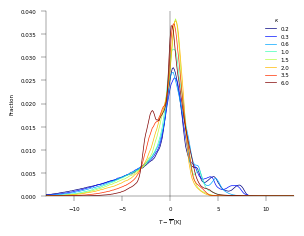

In [515]:
save_pdf_fig = True
plot_log = False
color_seq_exp = plt.cm.jet(np.linspace(0,1,n_exp))
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(hist_bin_centres, temp_hist_weight[i], color=color_seq_exp[i], label=f'{tau_lw[i]}')
ax.set_xlabel('$T-\overline{T}$ [K]')
ax.set_ylabel('Fraction')
if plot_log:
    ax.set_yscale('log')
    ax.set_ylim(10**-5, temp_hist_weight.max())
else:
    ax.set_ylim(0, temp_hist_weight.max())
ax.set_ylim(0, 0.04)
ylim = ax.get_ylim()
ax.vlines(0, ylim[0], ylim[1], lw=ax_linewidth, colors='k')
ax.set_xlim(hist_bin_centres[0], hist_bin_centres[-1])
if region == 'tropics':
    ax.legend(title='$\kappa$')
if save_fig or save_pdf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_pdf_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)